# The impact of co-starring in films on making a marriage between actors

## 1. Introduction
Many celebrity couples appeared from collaboration of actors in movies and TV series. But it is not clear whether it's some trend or just a coincidence. Here we are trying to answer that question by simple analysis of dependency of number of actors couples from number of video films where they participated together.

To my knowledge there were no similar research papers or even a ready datasets with actors couples.

## 2. Project background and aims
### 2.1. Within this project, I would like to explore the following:
1. Verify feasibility of acquiring required datasets.
2. Find if there is any dependency between number of movies where actors participated together and number of marriages between those actors.
3. If there is any dependency, try to identify a type of dependency.

### 2.2. For this project proposal, my aims are to:
1. Find data about which actor played in which movie.
2. Find data about actors marriages.
3. Estimate validity of the data and used approach.
4. Clean the data and transform it to the form acceptable for analysis.
5. Analyze dependency between collaboration and marriage, visualize it, make sensible outcome.

### 2.3. The following flow is assuming to be used:
![Data flow scheme](costarring-marriage-analytics-flow.png)

There were no any previous research papers or datasets found which suited the purpose of this research. Perhaps there are researches with wider thematic that include some aspects of the given research, but I did not find such either.

### 2.4. Disclaimer
It is important to understand that the marriage is much more complex domain that appeared in this research. It includes and has impact of psychological aspects, geography, culture and many other factors. So even if the analysis shown here shows something, or vice versa shows nothing, it can't be considered as the final and truth solution. But it can be used as a part of another deeper research, or as a start point for another research.
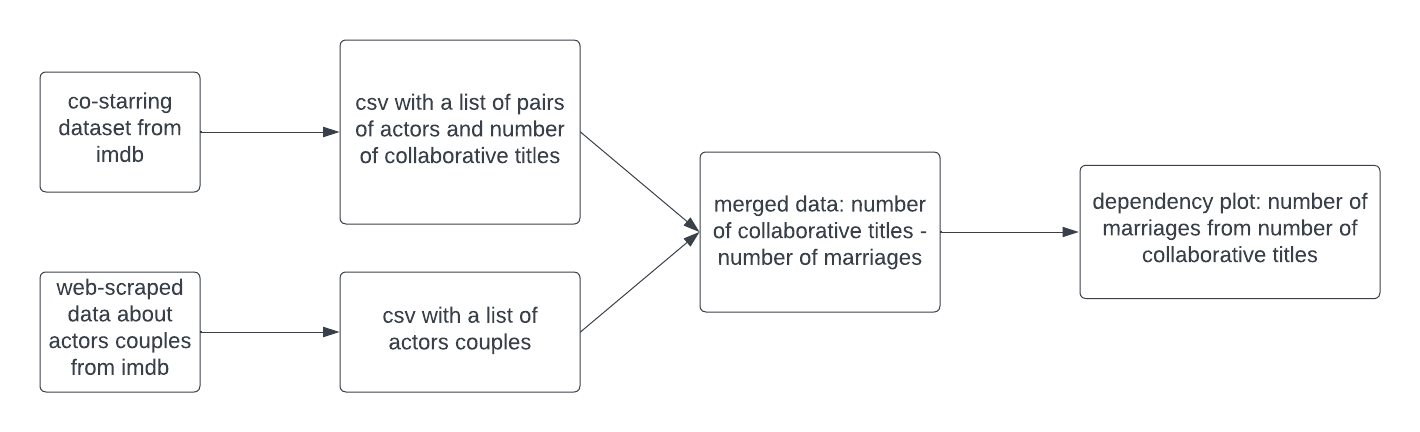
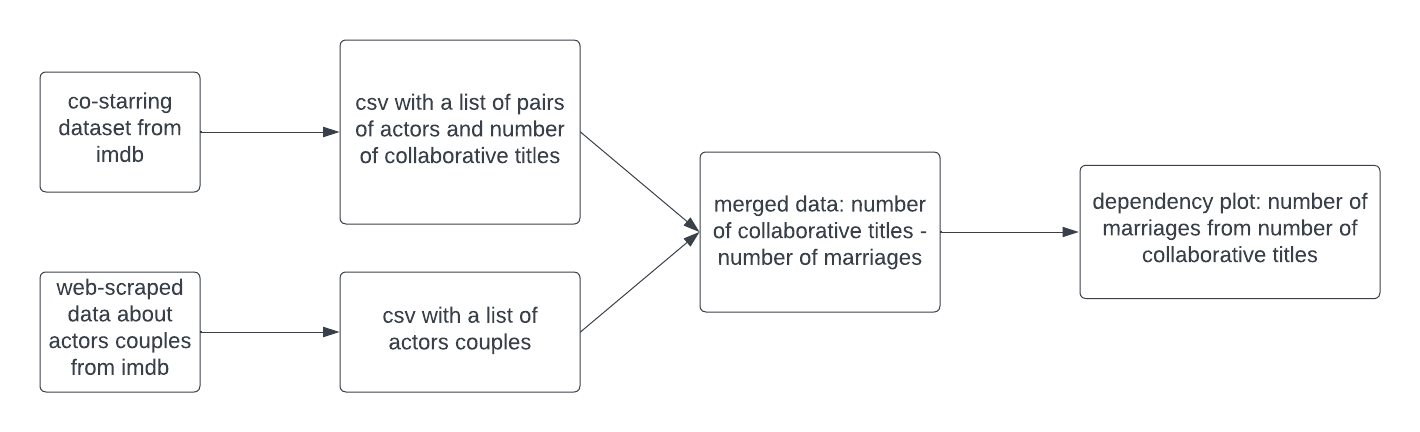

## 3. Data
IMDb is chosen as the main source of data as it provides as data about participation of actors in movies as data about their marriage in structured form. And those data can be linked with each other as the same system of identifiers is used across all the data. IMDb has its own datasets available for personal non-commercial usage [1], [9], [10]. Bot those datasets don't have actors marriage data. Such data can be acquired only by web-scraping from actors pages [3]. According to [9] and [10] it isn't allowed to use those data even for personal non-commercial purposes. Perhaps that is one of the reasons why I didn't find any research papers on the topic. So, in general, data used here are obtained in a not quiet a legal way, but anyway they are publicly available.

### 3.1. Data - collaboration of actors in movies
The idea is to acquire a new dataset with the following structure:
 - actor (string) - alphanumeric unique identifier of the actor
 - actress (string) – alphanumeric unique identifier of the actress
 - common_titles (integer) - number of collaborations
Where each row contains info about number of titles where the given pair collaborated.

For that purpose dataset [2] is used. The file is placed to raw_data/title.principals.tsv. That is a CSV file, it contains the principal cast/crew for titles and has the following columns [1]:
 - tconst (string) - alphanumeric unique identifier of the title
 - ordering (integer) – a number to uniquely identify rows for a given titleId
 - nconst (string) - alphanumeric unique identifier of the name/person
 - category (string) - the category of job that person was in
 - job (string) - the specific job title if applicable, else '\N'
 - characters (string) - the name of the character played if applicable, else '\N'
In the current archive only a small sample of those data is presented. Full data can be downloaded from [2].

We start with adding required imports and helper functions:

In [ ]:
import pandas as pd
import numpy as np

#fast group by in dataframe, see reference[7] for details
def group_by_tconst(self):
    keys, values = self.to_numpy().T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values, index[1:])
    df2 = pd.DataFrame({'title': ukeys, 'actors':  arrays })
    return df2

pd.DataFrame.group_by_tconst = group_by_tconst

#fast cartesian product of 2 numpy arrays, see reference[8] for details
def cartesian_product(arrays):
    array1 = arrays[0]
    array2 = arrays[1]
    dtype = np.result_type(array1, array2)
    arr = np.empty([len(array1), len(array2), 2], dtype=dtype)
    for i, a in enumerate(np.ix_(array1, array2)):
        arr[..., i] = a
    return arr.reshape(-1, 2)

Columns **tconst**, **nconst** and **category** are used to filter only actors and actresses, and create separate dataframes for actors and for actresses. Then each of those dataframes are grouped by **tconst** to get lists of actors and actresses for each title:

In [ ]:
principals = pd\
    .read_csv(
        'raw_data/title.principals.tsv',
        delimiter='\t',
        usecols=['tconst', 'nconst', 'category']
    )

actors = principals\
    .query('category == "actor" & tconst != "\\\\N" & nconst != "\\\\N"')\
    .drop('category', axis = 'columns')\
    .group_by_tconst()

actresses = principals\
    .query('category == "actress" & tconst != "\\\\N" & nconst != "\\\\N"')\
    .drop('category', axis = 'columns')\
    .group_by_tconst()

print('actors sample:')
print(actors.head(10))
print('actresses sample:')
print(actresses.head(10))

After we have actors and actresses, we want to join them by **title**, eliminate **title**, and calculate cartesian product **[actors]**x**[actresses]** to get list of all possible actor-actress collaborations for each title. For later grouping by **actor**-**actress** pairs we flatten dataframe of arrays of pairs to list of pairs:

In [ ]:
pairs = actors\
    .merge(actresses, on = 'title')\
    .drop('title', axis = 'columns')\
    .apply(cartesian_product, axis='columns')\
    .explode()\
    .to_list()

print('pairs sample:')
print(pairs.head(10))

Then next step is to apply grouping by **actor**-**actress* and count amount of collaborations for each pair to get a new dataset with the following structure:
 - actor (string) - alphanumeric unique identifier of the actor
 - actress (string) – alphanumeric unique identifier of the actor
 - common_titles (integer) - number of collaborations

In [9]:
groupedPairs = pd.DataFrame([p for p in pairs if type(p) != float], columns=['actor', 'actress'])\
    .groupby(['actor', 'actress'])\
    .size()\
    .reset_index(name='common_titles')

print('grouped pairs sample:')
print(groupedPairs.head(10))

It is stored to prepared_data/collaborated_actors.csv. In the current archive only a small sample of those data is presented. Full data can be downloaded from [14].

In [ ]:
groupedPairs.to_csv('prepared_data/collaborated_actors.csv', index=False)

### 3.2. Data - actors marriages
The idea is to acquire a new dataset with the following structure:
 - actor (string) - alphanumeric unique identifier of the actor
 - actress (string) – alphanumeric unique identifier of the actress
Where each row represents a marriage between 2 actors.

The dataset wanted can be built by combining 2 sources of data:
 1. Dataset from the section 3.1 [14]. The file is placed to prepared_data/collaborated_actors.csv. Structure of the file is described in the section 3.2. We want to use it to get a list of actors/actresses to find spouses for. I decided to use only actors as anyway
 2. Web-scraping of actors bio pages [3]. Those page contains info about spouses of an actor.

We start with adding required imports and helper functions:

In [9]:
import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import csv
import atomics
import threading
import time
from os.path import exists

async def gather_with_concurrency(n, *tasks):
    semaphore = asyncio.Semaphore(n)

    async def sem_task(task):
        async with semaphore:
            return await task

    return await asyncio.gather(*(sem_task(task) for task in tasks))

Then we define a function for scraping spouses of a single actor:

In [13]:
async def find_spouses(
        actor_id,
        session,
        results,
        progress_counter,
        actors_total,
        actor_couples_file,
        actor_couples_writer,
        actor_couples_file_write_lock,
        failed_actors_file,
        failed_actors_writer,
        failed_actors_file_write_lock,
        parsed_actors_file,
        parsed_actors_writer,
        parsed_actors_file_write_lock,
        parsed_actors,
        start_time
):
    try:
        progress_counter.inc()
        progress_counter_current = progress_counter.load()
        if progress_counter_current % 10000 == 0:
            print(f'processed {progress_counter_current}/{actors_total} actors, {len(results)} couples found, time taken: {time.time() - start_time} seconds')
            with actor_couples_file_write_lock:
                results_len = len(results)
                for _ in range(results_len):
                    actor_couples_writer.writerow(results.pop(0))
                actor_couples_file.flush()
            with parsed_actors_file_write_lock:
                parsed_actors_len = len(parsed_actors)
                for _ in range(parsed_actors_len):
                    parsed_actors_writer.writerow([parsed_actors.pop(0)])
                parsed_actors_file.flush()

        async with session.get(
            f"https://www.imdb.com/name/{actor_id}/bio",
            headers = {'User-Agent': f'My Cool User Agent {progress_counter_current}.0'}
        ) as response:
            if not response.ok:
                raise Exception('wrong code')

            parsed_actors.append(actor_id)

            page = await response.text()
            soup = BeautifulSoup(page, 'html.parser')

            table = soup.find(id='tableFamily')
            if not table:
                return
            spouse = table.find_all('tr')[0]
            if "Spouse" not in spouse.text:
                return
            for link in spouse.find_all("a"):
                link_details = link.get("href")
                if "/name/" in link_details:
                    results.append([actor_id, link_details.split('?')[0][6:]])
    except Exception as e:
        with failed_actors_file_write_lock:
            failed_actors_writer.writerow([actor_id])
            failed_actors_file.flush()
            print(f'!!!FAILED ACTOR: {actor_id}, {e.args}')

The next step is to define and run a function with the following logic:
1. Read **actor** column from collaborated_actors.csv
2. Deduplicate values in the read dataset and request spouses for each actor.
3. Save resulted spouse pairs to a new dataset prepared_data/actor_couples.csv

In [14]:
import os

async def scrape_spouses(actor_ids):
    conn = aiohttp.TCPConnector(limit=None, ttl_dns_cache=300)
    session = aiohttp.ClientSession(connector=conn)

    results = []

    progress_counter = atomics.atomic(width=4, atype=atomics.INT)

    actors_total = len(actor_ids)

    failed_actors_file = open('prepared_data/failed_actors.csv', 'w')
    failed_actors_writer = csv.writer(failed_actors_file)
    failed_actors_file_write_lock = threading.Lock()

    should_write_headers = not exists('prepared_data/actor_couples.csv') or os.stat('prepared_data/actor_couples.csv').st_size == 0
    actor_couples_file = open('prepared_data/actor_couples.csv', 'a')
    actor_couples_writer = csv.writer(actor_couples_file)
    actor_couples_file_write_lock = threading.Lock()
    if should_write_headers:
        actor_couples_writer.writerow(['actor', 'actress'])

    parsed_actors_file = open('prepared_data/parsed_actors.csv', 'a')
    parsed_actors_writer = csv.writer(parsed_actors_file)
    parsed_actors_file_write_lock = threading.Lock()
    parsed_actors = []

    start_time = time.time()

    await gather_with_concurrency(
        50,
        *[find_spouses(
            actor_id,
            session,
            results,
            progress_counter,
            actors_total,
            actor_couples_file,
            actor_couples_writer,
            actor_couples_file_write_lock,
            failed_actors_file,
            failed_actors_writer,
            failed_actors_file_write_lock,
            parsed_actors_file,
            parsed_actors_writer,
            parsed_actors_file_write_lock,
            parsed_actors,
            start_time
        ) for actor_id in actor_ids]
    )
    await session.close()

    failed_actors_file.close()
    actor_couples_file.close()
    parsed_actors_file.close()

In [15]:
import pandas as pd
from os.path import exists
import os

collaborated_actors = pd\
    .read_csv('prepared_data/collaborated_actors.csv', usecols=['actor'])\
    .actor\
    .tolist()

actor_ids = set(collaborated_actors)

if exists('prepared_data/actor_couples.csv') and os.stat('prepared_data/actor_couples.csv').st_size != 0:
    actor_ids = actor_ids - set(pd.read_csv('prepared_data/actor_couples.csv').actor.tolist())
if exists('prepared_data/parsed_actors.csv') and os.stat('prepared_data/parsed_actors.csv').st_size != 0:
    actor_ids = actor_ids - set(pd.read_csv('prepared_data/parsed_actors.csv', header=None)[0].tolist())

await scrape_spouses(actor_ids)

!!!FAILED ACTOR: nm12277923, ('wrong code',)
processed 10000/1035260 actors, 148 couples found, time taken: 1125.278903245926 seconds
processed 20000/1035260 actors, 140 couples found, time taken: 2284.290815114975 seconds
processed 30000/1035260 actors, 144 couples found, time taken: 3387.0060951709747 seconds
processed 40000/1035260 actors, 133 couples found, time taken: 4567.623227119446 seconds
processed 50000/1035260 actors, 138 couples found, time taken: 5768.042305231094 seconds
processed 60000/1035260 actors, 128 couples found, time taken: 7257.761655092239 seconds
processed 70000/1035260 actors, 130 couples found, time taken: 8475.183460235596 seconds
!!!FAILED ACTOR: nm13109082, ('wrong code',)
!!!FAILED ACTOR: nm11101321, ('wrong code',)
processed 80000/1035260 actors, 127 couples found, time taken: 9597.17602610588 seconds
processed 90000/1035260 actors, 130 couples found, time taken: 10713.090123176575 seconds
processed 100000/1035260 actors, 131 couples found, time taken:

CancelledError: 

In the result we have the following dataset:

In [ ]:
actor_couples = pd.read_csv('prepared_data/actor_couples.csv')
print('actor couples sample')
print(actor_couples.head(10))

### 3.3. Data flaws
There is a number of potential flaws in the data and approach used:
1. Only a single data source is used - IMDb. That implies a few issues:
   1. It has limited ability to verify the data. Ideally it would be good to add data from glamour magazines and, at least, wikipedia [13]. But it requires a lot of manual work or applying some machine learning algorithms for parsing.
   2. It has limited amount of data regarding geography. IMDb covers mostly the West World (UK, USA, West Europe, Australia) filmography and actors while there are huge amount movies and actors in other parts of the World. For example, worth adding Kinopoisk [11] and Douban [12].
2. IMDb dataset has equal entities for a movie and for a TV series episode. So a movie will be counted as one collaborative play, and TV series - as several collaborative plays depending on number of episodes. It's a matter of discussion what is the correct approach here. In my research I decided to count each episode as a separate movie.
3. In general, direction of the dependency I am trying to uncover in this research is unclear. I suppose that a number of marriages depends on a number of collaborations. But in fact it can be vice versa, or even in both ways depending on the context. Answer on that issue is not covered in my research. But it's possible if we take in the account dates of titles and marriages. Depending on what happens earlier we can try to identify some patterns and answer the question.

## 4. Analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

collaborated_actors = pd.read_csv('prepared_data/collaborated_actors.csv')
actor_couples = pd.read_csv('prepared_data/actor_couples.csv')

plot_data = collaborated_actors\
    .merge(actor_couples, on = ['actor', 'actress'])\
    .drop(['actor', 'actress'], axis = 'columns')\
    .groupby('common_titles')\
    .size()\
    .reset_index(name='marriages')

print('plot data sample')
print(plot_data.tail(10))

KeyboardInterrupt: 

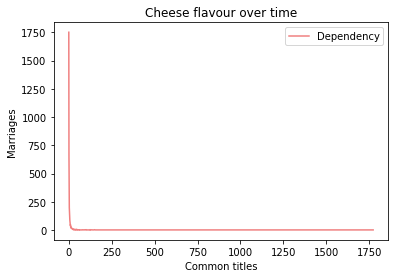

<Figure size 20000x10000 with 0 Axes>

In [10]:
plt.plot(plot_data.common_titles, plot_data.marriages, label='Dependency', color='lightcoral')
plt.legend()
plt.title("Cheese flavour over time")
plt.xlabel("Common titles")
plt.ylabel("Marriages")
plt.figure(figsize=(100,50), dpi= 200, facecolor='w', edgecolor='k')
plt.show()

## 7. References
[1] IMDb Datasets [Online]. Visited 2022, June 16. Available: [https://www.imdb.com/interfaces/](https://www.imdb.com/interfaces/)
[2] IMDb Titles Principals Dataset [Online]. Visited 2022, June 16. Available: [https://datasets.imdbws.com/title.principals.tsv.gz](https://datasets.imdbws.com/title.principals.tsv.gz)
[3] IMDb Actors Bio Pages [Online]. Visited 2022, June 16. Available: [https://www.imdb.com/name/<actor_id>/bio](https://www.imdb.com/name/<actor_id>/bio)
[4] Pandas Documentation [Online]. Visited 2022, June 16. Available: [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)
[5] NumPy Documentation [Online]. Visited 2022, June 16. Available: [https://numpy.org/doc/](https://numpy.org/doc/)
[6] Matplotlib Documentation [Online]. Visited 2022, June 16. Available: [https://matplotlib.org/stable/index.html](https://matplotlib.org/stable/index.html)
[7] Fast groupby with Pandas and NumPy [Online]. Visited 2022, June 16. Available: [https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby](https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby)
[8] Fast cartesian product of numpy arrays [Online]. Visited 2022, June 16. Available: [https://stackoverflow.com/questions/11144513/cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points](https://stackoverflow.com/questions/11144513/cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points)
[9] IMDb: Can I use IMDb data in my software? [Online]. Visited 2022, June 16. Available: [https://help.imdb.com/article/imdb/general-information/can-i-use-imdb-data-in-my-software/G5JTRESSHJBBHTGX](https://help.imdb.com/article/imdb/general-information/can-i-use-imdb-data-in-my-software/G5JTRESSHJBBHTGX)
[10] IMDb: Conditions of Use [Online]. Visited 2022, June 16. Available: [https://www.imdb.com/conditions](https://www.imdb.com/conditions)
[11] Kinopoisk [Online]. Visited 2022, June 16. Available: [https://www.kinopoisk.ru/](https://www.kinopoisk.ru/)
[12] Douban [Online]. Visited 2022, June 16. Available: [https://www.douban.com/](https://www.douban.com/)
[13] Wikipedia: List of film director and actor collaborations [Online]. Visited 2022, June 16. Available: [https://en.wikipedia.org/wiki/List_of_film_director_and_actor_collaborations](https://en.wikipedia.org/wiki/List_of_film_director_and_actor_collaborations)
[15] Full Actors Marriages Dataset built during the research: actor_couples.csv [Online]. Visited 2022, June 19. Available: []()
[16] Parallel web scraping https://betterprogramming.pub/how-to-make-parallel-async-http-requests-in-python-d0bd74780b8a
[17] https://github.com/doodspav/atomics